# 6章 決定木

SVMと同様に**決定木**(decision tree)は、分類と回帰の両方のタスクを実行できる柔軟性の高い機械学習アルゴリズムである。決定木は非常に強力で、複雑なデータセットに適合できる。たとえば、2章ではカリフォルニアの住宅価格データセットを使ってDecisionTreeegressorを訓練したが、うまく適合した(実際には、それを通り過ぎて過学習していた)。

決定木は、今日ある機械学習アルゴリズムのなかでも有数の力を持つファンダムフォレスト(7章参照)の基本構成要素でもある。

この章では、決定木の訓練、可視化、決定木による予測について説明してから、scikit-learnが使っているCART訓練アルゴリズムを深く掘り下げ、さらに決定木の正則化の方法と回帰のタスクでの使い方を説明する。最後に、決定木の限界について触れる。

## 6.1 決定木の訓練と可視化

決定木を理解するために、まずとにかく決定木を作って、どのように予測を行うのかを見てみよう。次のコードは、irisデータセットを使ってDecisionTreeClassifierを訓練する(4章参照)。

In [1]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

In [2]:
iris = load_iris()
X = iris.data[:, 2:] # 花弁の長さと幅
y = iris.target

tree_clf = DecisionTreeClassifier(max_depth=2)
tree_clf.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

訓練した決定木は、まずexport_graphviz()メソッドでiris_tree.dotというグラフ定義ファイルを出力すると、可視化できる。

In [3]:
# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "decision_trees"

def image_path(fig_id):
    return os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id)

In [16]:
from sklearn.tree import export_graphviz
from IPython.display import Image

In [5]:
export_graphviz(
    tree_clf,
    out_file=image_path("iris_tree.dot"),
    feature_names=iris.feature_names[2:],
    class_names=iris.target_names,
    rounded=True,
    filled=True
)

この.dotファイルは、graphvizパッケージのdotコマンドラインツールでPDFやPNGなどのさまざまな形式に変換できる。次のコマンドラインは、.dotファイルを.pngイメージファイルに変換する。

$ dot -Tpng iris_tree.dot -o iris_tree.png

最初の決定木は、図6-1に示すようなものである。

In [11]:
import pydot

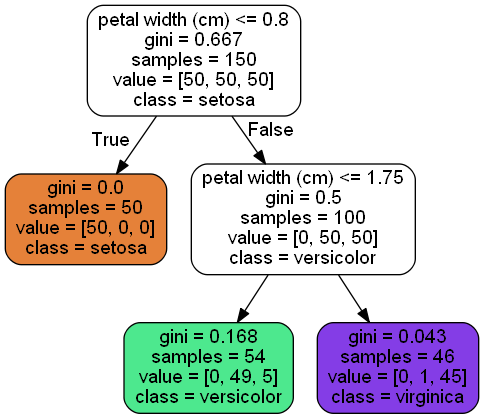

In [17]:
graph, = pydot.graph_from_dot_file(image_path("iris_tree.dot"))
graph.write_png(image_path("iris_tree.png"))
Image(image_path("iris_tree.png"))

## 6.2 決定木による予測

では、図6-1の木がどのように予測をするのかを見てみよう。あやめの花を見つけ、分類したいと思ったとする。ルートノード(root node、図の最上部で深さ0)からスタートする。このノードは、花の花弁の長さが2.45cm未満かどうかを尋ねてくる。答えがイエスなら、ルートノードの左側のノードに移る(深さ1、左)、この場合、そこは**葉ノード**(leaf node、子ノードがないノードのこと)なので、それ以上質問はない。単純に予測されたクラスを見ると、決定木はその花をセトナ種(class=setona)だと予測している。

また別の花を見つけ、今度は花弁の長さが2.45cmよりも長いものとする。すると、今度はルートの右側の子ノードに移らなければならない(深さ1、右)。このノードは葉ノードではなく、花弁の幅は1.75未満かどうかという別の質問がある。1.75cm未満なら、その端はたぶんバーシクルである(深さ2、左)。そうでなければ、バージニカである可能性が高い(深さ2、右)。実際には、これだけの単純なものである。

ノードのsamples属性は、そのノードが何個の訓練インスタンスを処理したかを示す。たとえば、100個の訓練インスタンスの花弁の長さが2.45cm以上で(深さ1、右)、そのなかの54個の花弁の幅が2だとすると、samplesは図に書かれている通りになる。ノードのvalue属性は、各クラスの訓練インスタンスのうち何個がこのノードの条件に当てはまるかを示す。たとえば、右下のノードの条件が当てはまるのは、セトナのなかで0個、バーシクルのなかで1個、バージニカのなかで45個であることを示している。最後に、ノードのgini属性はノードの**不純度**(impurity)を示す。ノードの条件に当てはまるすべての訓練インスタンスが同じクラスに属するなら、そのノードは「純粋」(gini=0)である。たとえば、深さ1、左のノードに当てはまるのはセトナ種の訓練インスタンスだけなので純粋であり、gini係数は0になる。式6-1は、訓練アルゴリズムが$i$番目のノードのジニスコア $G_i$をどのように計算するかを示している。たとえば、深さ2、左ノードのgini係数は、$1-(0/54)^2-(49/54)^2-(5/54)^2 \approx 0.168$にある。その他の**不純度の指標**(impurity measure)については、すぐあとで説明する。
$$
    G_i = 1 - \sum_{k=1}^n p_{i, k}^2 \tag{6-1}
$$

- $P_{i, k}$は、$i$番目のノードの訓練インスタンス数のなかのクラス$k$のインスタンスの割合。

図6-2は、決定木の決定境界を示している。太い縦線は、ルートノード(深さ0)の花弁長=2.45cmという決定境界を示す。左の領域は純粋(セトナ種だけ)なので、これ以上分割できない。しかし、右側は純粋なので、深さ1、右のノードが花弁幅1.75cm(破線で示されたもの)で分割している。max_depthが2に設定されているので、決定木はそこで止まっている。しかし、max_depthを3にしていれば、深さ2のふたつのノードは、もうひとつの決定境界(点線で示されたもの)を設けていただろう。

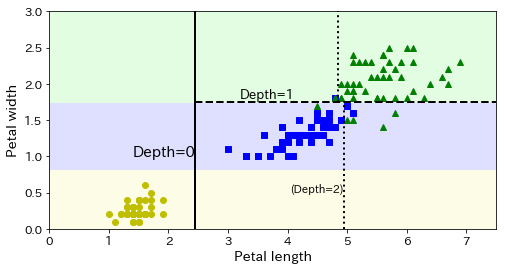

In [18]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[0, 7.5, 0, 3], iris=True, legend=False, plot_training=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if not iris:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    if plot_training:
        plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris-Setosa")
        plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris-Versicolor")
        plt.plot(X[:, 0][y==2], X[:, 1][y==2], "g^", label="Iris-Virginica")
        plt.axis(axes)
    if iris:
        plt.xlabel("Petal length", fontsize=14)
        plt.ylabel("Petal width", fontsize=14)
    else:
        plt.xlabel(r"$x_1$", fontsize=18)
        plt.ylabel(r"$x_2$", fontsize=18, rotation=0)
    if legend:
        plt.legend(loc="lower right", fontsize=14)

plt.figure(figsize=(8, 4))
plot_decision_boundary(tree_clf, X, y)
plt.plot([2.45, 2.45], [0, 3], "k-", linewidth=2)
plt.plot([2.45, 7.5], [1.75, 1.75], "k--", linewidth=2)
plt.plot([4.95, 4.95], [0, 1.75], "k:", linewidth=2)
plt.plot([4.85, 4.85], [1.75, 3], "k:", linewidth=2)
plt.text(1.40, 1.0, "Depth=0", fontsize=15)
plt.text(3.2, 1.80, "Depth=1", fontsize=13)
plt.text(4.05, 0.5, "(Depth=2)", fontsize=11)
plt.show()

## 6.3 クラスの確率の推計

決定木は、インスタンスが特定のクラス$k$に属する確率も推計できる。まず決定木は木構造をたどって当該インスタンスの葉ノードを見つけ、次にこのノードにあるクラス$k$の訓練インスタンスの割合を返す。たとえば、花弁の長さが5cmで幅が1.5cmのあやめを見つけたとする。対応する葉ノードは、深さ2、左ノードなので、決定木はセトナの確率0%(0/54)、バーシクルの確率90.7%(49/54)、バージニカの確率9.3$(5/54)を出力する。これをチェックしてみよう。

In [19]:
tree_clf.predict_proba([[5, 1.5]])

array([[0.        , 0.90740741, 0.09259259]])

In [20]:
tree_clf.predict([[5, 1.5]])

array([1])

間違いない。推計される確率は、図6-2の右下の矩形のなかならどこでも同じになることに注意しよう。たとえば、花弁の長さが6cm、幅1.5cmでも同じになる(この場合、バージニカの確率がもっとも高いことはグラフからは自明だが)。

## 6.4 CART訓練アルゴリズム

scikit-learnは、**CART**(Classification and Regression Tree)アルゴリズムを使って決定木(growing treeとも呼ばれる)を訓練する。考え方はごく単純で、まずひとつのフィーチャー$k$と閾値$t_k$(たとえば、花弁の長さ$geq$2.45cm)を使って訓練セットをふたつのサブセットに分割する。アルゴリズムは、どのようにして$k$と$t_k$を選ぶのだろうか。もっとも純粋なサブセット(サイズによって測られる)を作り出す($k$, $t_k$)のペアを探すのである。アルゴリズムが最小化しようとするコスト関数は式6-2である。
$$
    J(t, t_k) = \frac{m_{\rm left}}{m}G_{\rm left} + \frac{m_{\rm right}}{m} G_{\rm right} \\
    {\rm where}
    \begin{cases}
        G_{\rm left/right}は、左右のサブセットの不純度 \\
        m_{\rm left/right}は、左右のサブセットのインスタンス数
    \end{cases} \tag{6-2}
$$
訓練セットの2分割に成功したら、サブセットを同じ理論で分割し、次はサブサブセットの分割というように再帰的に分割する。深さの上限(max_depth)に達するか、不純度を下げる分割方法が見つからなければ、再帰を中止する。停止条件は、すぐあとで説明するその他のハイパーパラメータ(min_samples_split、min_samples_leaf、min_weight_fraction_leaf、max_leaf_nodes)によっても影響を受ける。

残念ながら、最適な木を見つけるという問題は、**NP完全**(NP-Complete)問題だということがわかっている。計算量が$O(\exp(m))$なので、ごく小規模な訓練セットでも、手に負えなくなる。「まずまずよい解」で満足しなければならないのは、そのためだ。

## 6.5 計算量

予測をするためには、決定木を根(ルート)から葉までたどらなければならない。決定木は一般にほぼ平衡なので、たどらなければならないノード数はおおよそ$O(n \times m\log_2(m))$個である。各ノードでは、1個のフィーチャーの値をチェックするだけでよいので、予測全体の計算量は、フィーチャーの数にかかわらず、$O(\log_2(m))$になる。

しかし、訓練アルゴリズムは、各ノードですべてのサンプルのすべてのフィーチャー(max_featureが設定されている場合はそれよりも少ない)を比較する。そのため、訓練の計算量は$O(n \times m \log(m))$になる。小規模な訓練セット(インスタンス数が数千個未満)では、scikit-learnはデータをプレソートして(presort=Trueを設定する)訓練を高速化できるが、それよりも大きな訓練セットではこうすると訓練がかなり遅くなる。

## 6.6 ジニ不純度かエントロピーか

デフォルトでは、ジニ不純度(GINI impurity)が使われるが、criterionハイパーパラメータを"entropy"にすると、不純度の指標として**エントロピー**(entropy)を使える。エントロピーの概念は、熱力学で分子の乱雑さの指標として使ったのが最初である。分子が静止し、安定すると、エントロピーは0に近づく。この概念は、その後シャノンの**情報理論**(information theory)を含むさまざまな領域に拡散していった。情報理論では、メッセージの平均的な情報量を表す言葉になった。すべてのメッセージが同じなら、エントロピーは0である。機械学習では、エントロピーが不純度の指標としてよく使われる。セット(集合)がひとつのクラスに属するインスタンス(要素)だけから構成されている場合、セットのエントロピーは0である。式6-3は、$i$番目のノードのエントロピーの定義を示している。たとえば、図6-1の深さ2、左ノードのエントロピーは、$-\frac{49}{54}\log \left(\frac{49}{54}\right) - \frac{5}{54} \log\left(\frac{5}{54}\right) \approx 0.31$である。
$$
    H_i = -\sum_{k=1, p_{i, k} \neq 0}^n p_{i, k} \log(p_{i, k}) \tag{6-3}
$$
では、ジニ不純度とエントロピーのどちらを使うのだろうか。実は、ほとんどの場合、どちらを使っても大差はない。どちらを使っても同じような木になる。ジニ不純度の方がわずかに高速なので、これがデフォルトになっているのはよい。しかし、両者が異なる場合、ジニ不純度は再頻出クラスを木のなかに専用のブランチ(枝)に分離する傾向があるのに対し、エントロピーはそれよりもわずかに平衡の取れた木をつくる傾向がある。

## 6.7 正則化ハイパーパラメータ

決定木は、訓練データに対してほとんど先入観(assumption)を持たない(たとえば線形モデルなら、データが線形に分布していると最初から決めつけている)。制約を設けなければ、木構造は訓練データに合わせて自らを調整し、訓練データに密接に適合する。つまり、過学習しやすい。このようなモデルは、**ノンパラメトリックモデル**(nonparametric model)と呼ばれることが多い。それは、パラメータを持たないからではなく(むしろたくさんあることが多い)、訓練に先立ってパラメータの数が決定しておらず、モデル構造がデータに密接に適合できるからである。それに対し、線形モデルなどの**パラメトリックモデル**(parametric model)は、あらかじめ決められた数のパラメータがあるため、自由度が制限され、過学習のリスクが低くなっている(しかし、過小適合のリスクは高くなっている)。

訓練データへの過学習を防ぐためには、決定木の訓練中の自由に制限を加える必要がある。ご存知のように、これは正則化と呼ばれるものである。正則化パラメータは、使うアルゴリズムによって異なるが、一般に少なくとも決定木の深さの上限は制限できる。scikit-learnでは、max_depthハイパーパラメータで設定する(デフォルトは、無制限という意味のNoneである)。max_depthを制限すると、モデルが正則化され、過学習のリスクが低くなる。

DecisionTreeClassifierクラスは、ほかにも決定木の形に制限を加えるパラメータを持っている。min_samples_leaf(ノードを分割するために必要なサンプル数の下限)、min_samples_leaf(葉ノードが持たなければならないサンプル数の下限)、min_weight_fraction_leaf(min_samples_leafと同じだが、重みを持つインスタンスの総数の割合で表現される)、max_leaf_nodes(葉ノードの数の上限)、max_features(各ノードで分割のために評価されるフィーチャー数の上限)がそうだ。min_\*ハイパーパラメータを増やすかmax_\*ハイパーパラメータを減らせば、モデルを正則化できる。

図6-3は、moonsデータセット(5章で初めて使ったもの)で訓練したふたつの決定木を示している。左側の決定木はデフォルトのハイパーパラメータ(つまり制限なし)で訓練されているのに対し、右側の決定木はmin_samples_leaf=4を指定して訓練されている。左側のモデルが過学習していることはかなりはっきりしているが、右側のモデルはそれよりも汎化性能が高いだろう。

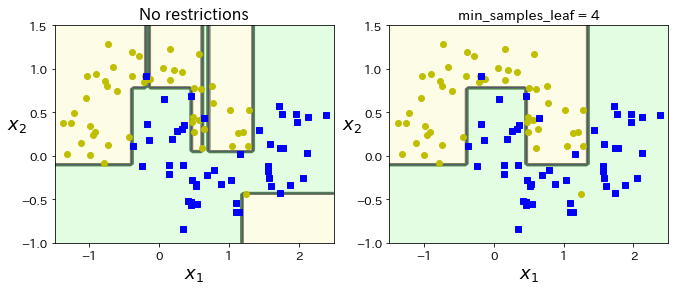

In [21]:
from sklearn.datasets import make_moons
Xm, ym = make_moons(n_samples=100, noise=0.25, random_state=53)

deep_tree_clf1 = DecisionTreeClassifier(random_state=42)
deep_tree_clf2 = DecisionTreeClassifier(min_samples_leaf=4, random_state=42)
deep_tree_clf1.fit(Xm, ym)
deep_tree_clf2.fit(Xm, ym)

plt.figure(figsize=(11, 4))
plt.subplot(121)
plot_decision_boundary(deep_tree_clf1, Xm, ym, axes=[-1.5, 2.5, -1, 1.5], iris=False)
plt.title("No restrictions", fontsize=16)
plt.subplot(122)
plot_decision_boundary(deep_tree_clf2, Xm, ym, axes=[-1.5, 2.5, -1, 1.5], iris=False)
plt.title("min_samples_leaf = {}".format(deep_tree_clf2.min_samples_leaf), fontsize=14)
plt.show()